# A-Team Machine Learning Project

### Counter Strike : Global Operations

Quick overview of the Notebook:

1. Data import & **Pre-Processing** (import / *EDA* / *factorizing* / nulls / outliers) **!!! factorize also test data**

2. **Train-test** split (one-hot-encoding of categoricals / **standardization** / split)

3. **Feature Engineering** (run benchmark logit & feature importance of basic model // *filtering methods* (chi^2, IG) & rerun benchmark // *embedded methods* (lasso), rerun benchmark & extract selected features

4. First **Model**: Apply PCA & run LDA 

5. Challenger Models: selected ML algorithms w final df

6. Final Model: **Ensemble Method** Voting/StackingClassifier


In [ ]:
# Google Drive setup

#from google.colab import drive
#drive.mount('/content/drive')

# 1. Data import & Pre-Processing

## 1.1 Import

### 1.1.1 Import libraries

In [ ]:
#! conda install scikit-learn -y
#! conda update -n base conda -y

In [ ]:
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>")) # Increase cell width
display(HTML("<style>.rendered_html { font-size: 16px; }</style>")) # Increase font size

# Larger figures

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline  

import pandas as pd
import numpy as np
import math

from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from sklearn.metrics import plot_confusion_matrix, accuracy_score

### 1.1.2 Load Dataset

In [ ]:
# df_train = pd.read_csv('./Data/training_set.csv')
# df_test = pd.read_csv('./Data/test_set.csv')

#df_train = pd.read_csv('/content/drive/Shared drives/ML2 project/training_set.csv') # for Collab
#df_test = pd.read_csv('/content/drive/Shared drives/ML2 project/test_set.csv') # for Collab
df_train = pd.read_csv('training_set.csv')
df_test = pd.read_csv('test_set.csv')

results_df = pd.DataFrame(columns=['Approach', 'Accuracy']) # create df to store results of models

df_test.head()

,time_left,ct_score,t_score,map,bomb_planted,ct_health,t_health,ct_armor,t_armor,ct_money,t_money,ct_helmets,t_helmets,ct_defuse_kits,ct_players_alive,t_players_alive,ct_weapon_ak47,t_weapon_ak47,ct_weapon_aug,t_weapon_aug,ct_weapon_awp,t_weapon_awp,ct_weapon_bizon,t_weapon_bizon,ct_weapon_cz75auto,t_weapon_cz75auto,ct_weapon_elite,t_weapon_elite,ct_weapon_famas,t_weapon_famas,ct_weapon_g3sg1,t_weapon_g3sg1,ct_weapon_galilar,t_weapon_galilar,ct_weapon_glock,t_weapon_glock,ct_weapon_m249,t_weapon_m249,ct_weapon_m4a1s,t_weapon_m4a1s,...,ct_weapon_p90,t_weapon_p90,ct_weapon_r8revolver,t_weapon_r8revolver,ct_weapon_sawedoff,t_weapon_sawedoff,ct_weapon_scar20,t_weapon_scar20,ct_weapon_sg553,t_weapon_sg553,ct_weapon_ssg08,t_weapon_ssg08,ct_weapon_ump45,t_weapon_ump45,ct_weapon_xm1014,t_weapon_xm1014,ct_weapon_deagle,t_weapon_deagle,ct_weapon_fiveseven,t_weapon_fiveseven,ct_weapon_usps,t_weapon_usps,ct_weapon_p250,t_weapon_p250,ct_weapon_p2000,t_weapon_p2000,ct_weapon_tec9,t_weapon_tec9,ct_grenade_hegrenade,t_grenade_hegrenade,ct_grenade_flashbang,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade
0,175.00,11.0,4.0,de_vertigo,False,500.0,500.0,400.0,300.0,700.0,550.0,0.0,0.0,1.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,94.95,8.0,4.0,de_dust2,False,400.0,450.0,400.0,477.0,10300.0,6900.0,4.0,5.0,4.0,4.0,5.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,4.0,2.0,2.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0
2,14.93,14.0,10.0,de_dust2,False,366.0,100.0,395.0,98.0,2350.0,2600.0,3.0,1.0,3.0,4.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,46.27,12.0,15.0,de_nuke,False,400.0,446.0,399.0,434.0,300.0,27000.0,3.0,5.0,3.0,4.0,5.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0
4,37.07,18.0,18.0,de_train,False,100.0,200.0,100.0,200.0,10100.0,20950.0,1.0,2.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
df_train['round_winner'].replace(['CT','T'],[1.0,0.0],inplace=True)

df_train['bomb_planted'].replace([True,False],[1.0,0.0],inplace=True)
df_test['bomb_planted'].replace([True,False],[1.0,0.0],inplace=True)

In [ ]:
# We see that maybe some columns have only "0"
array_zeros= np.where(df_train.sum()==0)
list_only_zero = df_train.columns[list(array_zeros)]
list_only_zero

/usr/local/lib/python3.6/dist-packages/pandas/core/indexes/base.py:4107: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


Index(['ct_weapon_bizon', 'ct_weapon_g3sg1', 'ct_weapon_m249', 't_weapon_m249',
       'ct_weapon_negev', 'ct_weapon_r8revolver', 'ct_weapon_sawedoff'],
      dtype='object')

# if we do this before Rayan's it will not work

In [ ]:
# Check all the columns with unique values
lista = []
for col in df_train.columns:
    lista.append(len(df_train.loc[:,col].unique()))

print("There are %d columns to be removed" %sum(pd.Series(lista) == 1.0))
filter_unique= pd.Series(lista) != 1.0
print("Columns %s" %df_train.columns[~filter_unique])

variables_exclude = df_train.columns[~filter_unique]

There are 7 columns to be removed
Columns Index(['ct_weapon_bizon', 'ct_weapon_g3sg1', 'ct_weapon_m249', 't_weapon_m249',
       'ct_weapon_negev', 'ct_weapon_r8revolver', 'ct_weapon_sawedoff'],
      dtype='object')


In [ ]:
# For test set, since we do not have the last column round_winner
filter_unique2 = filter_unique[:-1]

In [ ]:
# We remove those unique values columns
df_train = df_train.loc[:,df_train.columns[filter_unique]]

df_test = df_test.loc[:,df_test.columns[filter_unique2]]

In [ ]:
print(df_train.shape)
print(df_test.shape)

(82014, 90)
(40396, 89)


## 1.3 Factorization of variables

In [ ]:
#### create zero columns for all features to follow

### make sure to create features for all X datasets

In [ ]:
## go through variables and define which should be categoricals (check w .dtypes)

# hr_df['sales'] = hr_df.sales.astype('category') ## change categoric variables to 'category'

In [ ]:
variables_exclude #variables previously excluded

Index(['ct_weapon_bizon', 'ct_weapon_g3sg1', 'ct_weapon_m249', 't_weapon_m249',
       'ct_weapon_negev', 'ct_weapon_r8revolver', 'ct_weapon_sawedoff'],
      dtype='object')

In [ ]:
# Create weapon classes (pistol / assault / SMG / sniper / shotgun)
# Create lists for each weapon class & team

t_pistols = df_train['t_weapon_deagle'] + df_train['t_weapon_cz75auto'] + df_train['t_weapon_glock'] + df_train['t_weapon_r8revolver']\
+ df_train['t_weapon_fiveseven'] + df_train['t_weapon_usps'] + df_train['t_weapon_p250'] + df_train['t_weapon_p2000']
#df_train['t_pistol'] = t_pistols

ct_pistols = df_train['ct_weapon_deagle'] + df_train['ct_weapon_cz75auto'] + df_train['ct_weapon_glock']\
+ df_train['ct_weapon_fiveseven'] + df_train['ct_weapon_usps'] + df_train['ct_weapon_p250'] + df_train['ct_weapon_p2000']
#+ df_train['ct_weapon_r8revolver']
#df_train['ct_pistol'] = ct_pistols

t_assault = df_train['t_weapon_ak47'] +df_train ['t_weapon_aug'] + df_train['t_weapon_bizon'] +df_train['t_weapon_famas'] + df_train['t_weapon_galilar']\
+ df_train['t_weapon_m4a1s'] + df_train['t_weapon_m4a4'] + df_train['t_weapon_negev'] + df_train['t_weapon_sg553']\
+ df_train['t_weapon_ump45'] + df_train['t_weapon_tec9']
#+ df_train['t_weapon_m249']
#df_train['t_assault'] = t_assault

ct_assault = df_train['ct_weapon_ak47'] +df_train ['ct_weapon_aug'] +df_train['ct_weapon_famas'] + df_train['ct_weapon_galilar']\
+ df_train['ct_weapon_m4a1s'] + df_train['ct_weapon_m4a4'] + df_train['ct_weapon_sg553']\
+ df_train['ct_weapon_ump45'] + df_train['ct_weapon_tec9']
#+ df_train['ct_weapon_m249'] + df_train['ct_weapon_bizon'] + df_train['ct_weapon_negev'] 
#df_train['ct_assault'] = ct_assault

t_smg = df_train['t_weapon_mac10'] + df_train['t_weapon_mag7'] + df_train['t_weapon_mp5sd'] + df_train['t_weapon_mp7'] \
+ df_train['t_weapon_mp9']+ df_train['t_weapon_p90']
#df_train['t_smg'] = t_smg

ct_smg = df_train['ct_weapon_mac10'] + df_train['ct_weapon_mag7'] + df_train['ct_weapon_mp5sd'] + df_train['ct_weapon_mp7'] \
+ df_train['ct_weapon_mp9']+ df_train['ct_weapon_p90']
#df_train['ct_smg'] = ct_smg

t_sniper = df_train['t_weapon_awp'] + df_train['t_weapon_g3sg1'] + df_train['t_weapon_scar20'] + df_train['t_weapon_ssg08']
#df_train['t_sniper'] = t_sniper

ct_sniper = df_train['ct_weapon_awp'] + df_train['ct_weapon_scar20'] + df_train['ct_weapon_ssg08']
#+ df_train['ct_weapon_g3sg1'] 
#df_train['ct_sniper'] = ct_sniper

t_shotgun = df_train['t_weapon_nova'] + df_train['t_weapon_sawedoff'] + df_train['t_weapon_xm1014']
#df_train['t_shotgun'] = t_shotgun

ct_shotgun = df_train['ct_weapon_nova'] + df_train['ct_weapon_xm1014']
# + df_train['ct_weapon_sawedoff']
#df_train['ct_shotgun'] = ct_shotgun

t_explosives = df_train['t_grenade_hegrenade'] + df_train['t_grenade_molotovgrenade'] + df_train['t_grenade_smokegrenade']\
 + df_train['t_grenade_flashbang'] + df_train['t_grenade_incendiarygrenade'] + df_train['t_grenade_decoygrenade']
#df_train['t_explosive'] = t_explosives

ct_explosives = df_train['ct_grenade_hegrenade'] + df_train['ct_grenade_molotovgrenade'] + df_train['ct_grenade_smokegrenade']\
+ df_train['ct_grenade_flashbang'] + df_train['ct_grenade_incendiarygrenade'] + df_train['ct_grenade_decoygrenade']

# ct_explosives_list = ['ct_grenade_hegrenade','ct_grenade_molotovgrenade','ct_grenade_smokegrenade','ct_grenade_flashbang','ct_grenade_incendiarygrenade','ct_grenade_decoygrenade']
# ct_explosives = df_train[ct_explosives_list]
#df_train['ct_explosive'] = ct_explosives

In [ ]:
new_categorizations = {"t_pistols":t_pistols,"ct_pistols":ct_pistols,"t_assault":t_assault,"ct_assault":ct_assault,"t_smg":t_smg,
                       "ct_smg":ct_smg,"t_assault":t_assault,"ct_assault":ct_assault,"t_sniper":t_sniper,"ct_sniper":ct_sniper,
                       "t_shotgun":t_shotgun,"ct_shotgun":ct_shotgun,"t_explosives":t_explosives,"ct_explosives":ct_explosives}
#new_categorizations2 = redefine n_c for test data

new_variables = pd.DataFrame.from_dict(new_categorizations)
#new_variables2 = pd.DataFrame.from_dict(new_categorizations2)

df_train = pd.concat([df_train,new_variables],axis=1)
#df_test = pd.concat([df_test,new_variables2],axis=1)

In [ ]:
# Bucketing money into 4 new columns 20,000 range

bins= ['low', 'midlow','midhigh','high']

df_train['t_money_cat'] = pd.cut(df_train['t_money'], bins=[0, 20000, 40000, 60000, 80000], labels=bins, include_lowest=True).astype('category')
df_train['ct_money_cat'] = pd.cut(df_train['ct_money'], bins=[0, 20000, 40000, 60000, 80000], labels=bins, include_lowest=True).astype('category')


In [ ]:
# Time left binned into quarters

time_bins= ['Q1','Q2','Q3','Q4']

df_train['time_quarter'] = pd.cut(df_train['time_left'], bins=[0, 55, 95, 167, 175], labels=time_bins, include_lowest=True)

df_train.iloc[:,-4:].head()

,ct_explosives,t_money_cat,ct_money_cat,time_quarter
0,6.0,low,midlow,Q2
1,0.0,midhigh,midlow,Q4
2,18.0,low,low,Q4
3,12.0,low,low,Q2
4,0.0,low,low,Q3


In [ ]:
# diversity of weapon choice

#df_train['t_all_weapons'] = np.where((df_train['t_sniper'] > 0) & (df_train['t_shotgun'] > 0) & (df_train['t_assault'] > 0) &\
#                              (df_train['t_smg'] > 0) & (df_train['t_pistols'] > 0), 1, 0 )

df_train['ct_all_weapons'] = np.where((df_train['ct_sniper'] > 0) & (df_train['ct_shotgun'] > 0) & (df_train['ct_assault'] > 0) &\
                              (df_train['ct_smg'] > 0) & (df_train['ct_pistols'] > 0), 1, 0 )


df_train['t_all_assaults'] = np.where((df_train['t_assault'] > 0) & (df_train['t_smg'] > 0), 1, 0 )

df_train['ct_all_assaults'] = np.where((df_train['ct_assault'] > 0) & (df_train['ct_smg'] > 0), 1, 0 )

In [ ]:
#df_train['t_all_weapons'].sum() ## == 0; turns out the full combination was never reached

In [ ]:
###### NON-RELEVANT FEATURE

# # Time left & bomb planted interaction

# df_train['t_bomb_q1'] = np.where((df_train['time_quarter'] == 'Q1') & (df_train['bomb_planted'] > 0) , 1, 0 ) #### identical to bomb_planted
# df_train['t_bomb_q2'] = np.where((df_train['time_quarter'] == 'Q2') & (df_train['bomb_planted'] > 0) , 1, 0 ) ## == 0
# df_train['t_bomb_q3'] = np.where((df_train['time_quarter'] == 'Q3') & (df_train['bomb_planted'] > 0) , 1, 0 ) ## == 0
# df_train['t_bomb_q4'] = np.where((df_train['time_quarter'] == 'Q4') & (df_train['bomb_planted'] > 0) , 1, 0 ) ## == 0

In [ ]:
# Map size & gun types interactions
# Given that Cache3, Nuke, Overpass & Dust2 are the largest maps respectively
# Vertigo and Train the smallest maps

df_train['t_largemap_sniper'] = np.where((df_train['map'] == 'de_nuke') |(df_train['map'] == 'de_cache')\
                                         | (df_train['map'] == 'de_overpass') | (df_train['map'] == 'de_dust2')\
                                         & (df_train['t_sniper'] > 0) , 1, 0 )

df_train['ct_largemap_sniper'] = np.where((df_train['map'] == 'de_nuke') |(df_train['map'] == 'de_cache')\
                                         | (df_train['map'] == 'de_overpass') | (df_train['map'] == 'de_dust2')\
                                         & (df_train['ct_sniper'] > 0), 1, 0 )


df_train['t_smallmap_sniper'] = np.where((df_train['map'] == 'de_vertigo') | (df_train['map'] == 'de_train') \
                                       & (df_train['t_assault'] > 0) | (df_train['t_smg'] > 0) , 1, 0 )

df_train['ct_smallmap_sniper'] = np.where((df_train['map'] == 'de_vertigo') | (df_train['map'] == 'de_train') \
                                       & (df_train['ct_assault'] > 0) | (df_train['ct_smg'] > 0) , 1, 0 )

In [ ]:
# Create round count

df_train['round_count'] = df_train['ct_score']+df_train['t_score']+1

In [ ]:
# ALL ALIVE >400 health points

df_train['t_all_alive'] = (df_train['t_health']>400).astype('float')
df_train['ct_all_alive'] = (df_train['ct_health']>400).astype('float')

## 1.3 Impute Null Values, Check Outliers

### 1.3.1 Null Values

In [ ]:
#check for nulls 
missing_values = df_train.isnull().sum()
missing_values[0:]

time_left             0
ct_score              0
t_score               0
map                   0
bomb_planted          0
                     ..
t_smallmap_sniper     0
ct_smallmap_sniper    0
round_count           0
t_all_alive           0
ct_all_alive          0
Length: 115, dtype: int64

In [ ]:
df_train.isnull().sum().sum() # zero null values

0

### 1.3.2 Outlier Detection

In [ ]:
# from sklearn.neighbors import LocalOutlierFactor

# # identify outliers in the training dataset
# lof = LocalOutlierFactor()
# yhat = lof.fit_predict(train_X.loc[:,train_X.columns!='map'])

# # select all rows that are not outliers
# mask = yhat != -1

# #outliers = train_X[~mask]

# train_X = train_X[mask]
# train_y = train_y[mask]

In [ ]:
#outliers.describe()

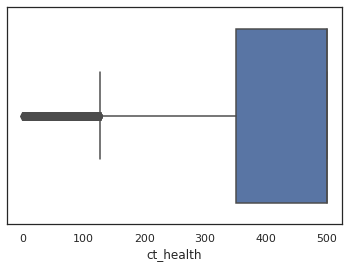

In [ ]:
import seaborn as sns
sns.boxplot(data=df_train,x=df_train['ct_health'])

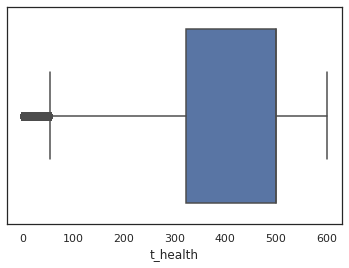

In [ ]:
sns.boxplot(data=df_train,x=df_train['t_health'])

In [ ]:
#df_train.loc[df_train['t_health']>500,'ct_weapon_galilar':].sum(axis=0) # error in row, 6 vs 4 player - delete outlier

In [ ]:
df_train.loc[df_train['t_health']>500,:]

,time_left,ct_score,t_score,map,bomb_planted,ct_health,t_health,ct_armor,t_armor,ct_money,t_money,ct_helmets,t_helmets,ct_defuse_kits,ct_players_alive,t_players_alive,ct_weapon_ak47,t_weapon_ak47,ct_weapon_aug,t_weapon_aug,ct_weapon_awp,t_weapon_awp,t_weapon_bizon,ct_weapon_cz75auto,t_weapon_cz75auto,ct_weapon_elite,t_weapon_elite,ct_weapon_famas,t_weapon_famas,t_weapon_g3sg1,ct_weapon_galilar,t_weapon_galilar,ct_weapon_glock,t_weapon_glock,ct_weapon_m4a1s,t_weapon_m4a1s,ct_weapon_m4a4,t_weapon_m4a4,ct_weapon_mac10,t_weapon_mac10,...,ct_weapon_tec9,t_weapon_tec9,ct_grenade_hegrenade,t_grenade_hegrenade,ct_grenade_flashbang,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade,round_winner,t_pistols,ct_pistols,t_assault,ct_assault,t_smg,ct_smg,t_sniper,ct_sniper,t_shotgun,ct_shotgun,t_explosives,ct_explosives,t_money_cat,ct_money_cat,time_quarter,ct_all_weapons,t_all_assaults,ct_all_assaults,t_largemap_sniper,ct_largemap_sniper,t_smallmap_sniper,ct_smallmap_sniper,round_count,t_all_alive,ct_all_alive
46347,175.0,0.0,0.0,de_vertigo,0.0,400.0,600.0,0.0,0.0,3200.0,4800.0,0.0,0.0,0.0,4.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,low,low,Q4,0,0,0,0,0,1,1,1.0,1.0,0.0


In [ ]:
# Delete outlier w row index 46347

df_train = df_train.drop(df_train.index[46347])

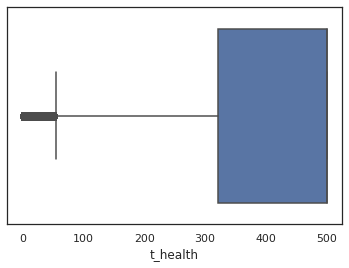

In [ ]:
sns.boxplot(data=df_train,x=df_train['t_health'])

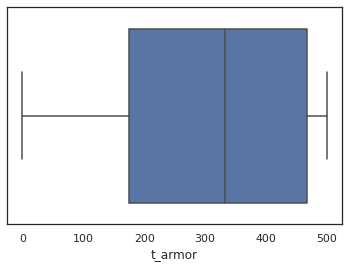

In [ ]:
sns.boxplot(data=df_train,x=df_train['t_armor']) # conclusion no outlier no atcion needed

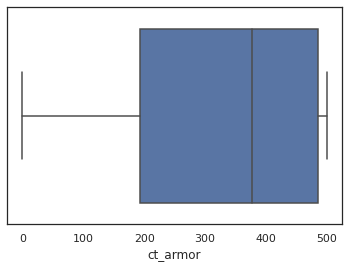

In [ ]:
sns.boxplot(data=df_train,x=df_train['ct_armor']) # conclusion no outlier no atcion needed

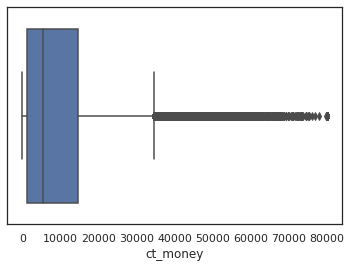

In [ ]:
sns.boxplot(data=df_train,x=df_train['ct_money'])

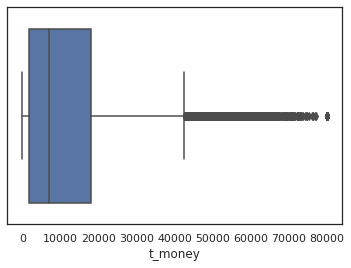

In [ ]:
sns.boxplot(data=df_train,x=df_train['t_money'])

# 2. Train-test Split

## 2.1 One-Hot-Encoding of Categorical Variables

As we have created various categoricals, we have to apply one-hot-encoding now to create dummy variables for the respective features. 

In [ ]:
from collections import defaultdict, Counter # Utils
sns.set(style="white")                       # Tuning the style of charts
import warnings                              # Disable some warnings

warnings.filterwarnings("ignore",category=DeprecationWarning)


#### create Loop to run one-hot-encoding for both train & test data

X_sets = [df_train, df_test]
columns_to_drop = [] # if any columns should be excluded
LIMIT_DUMMIES = 100 # for categorical variables with more than that many values, we only keep the more frequent ones

# define functions for Loop

def select_dummy_values(train, features):
    dummy_values = {}
    for feature in features:
        values = [
            value
            for (value, _) in Counter(train[feature]).most_common(LIMIT_DUMMIES)
        ]
        dummy_values[feature] = values
    return dummy_values

def dummy_encode_dataframe(df):
    for (feature, dummy_values) in DUMMY_VALUES.items():
        for dummy_value in dummy_values:
            dummy_name = u'%s_value_%s' % (feature, dummy_value)
            df[dummy_name] = (df[feature] == dummy_value).astype(float)
        del df[feature]
        print('Dummy-encoded feature %s' % feature)


for df in X_sets:
    
    # Get the column names
    numerical_columns = list(df.select_dtypes(include=[np.number]).columns)
    categorical_columns = list(df.select_dtypes(include=[object,'category']).columns)
    date_columns = list(df.select_dtypes(include=['<M8[ns]']).columns)

    # Print a quick summary of what we just loaded
    print("Loaded dataset")
    print("   Rows: %s" % df.shape[0])
    print("   Columns: %s (%s num, %s cat, %s date)" % (df.shape[1], 
                                                        len(numerical_columns), len(categorical_columns),
                                                        len(date_columns)))
    
    # Limit number of distinct values for selected categoricals
    DUMMY_VALUES = select_dummy_values(df, [x for x in categorical_columns if not x in columns_to_drop])
    
    # Add dummy columns to df
    dummy_encode_dataframe(df)
    

Loaded dataset
   Rows: 82013
   Columns: 115 (111 num, 4 cat, 0 date)
Dummy-encoded feature map
Dummy-encoded feature t_money_cat
Dummy-encoded feature ct_money_cat
Dummy-encoded feature time_quarter
Loaded dataset
   Rows: 40396
   Columns: 89 (88 num, 1 cat, 0 date)
Dummy-encoded feature map


## 2.2 Feature Scaling (Normalization)

In [ ]:
# Compute scaled values for our data 

df_train = df_train.reset_index() # to assure sklearn runs smoothly
df_train.pop('index')

from sklearn.preprocessing import StandardScaler

X1 = df_train.drop(columns='round_winner').values
df_train_std = StandardScaler().fit(X1).transform(X1)

X2 = df_test.values
test_X_std = StandardScaler().fit(X2).transform(X2)

In [ ]:
#df_train['round_winner'].replace([1.0,0.0],[1,0],inplace=True)

In [ ]:
# Establish dataframe structure with respective feature names

df_train_std = pd.DataFrame(df_train_std)
df_train_std.columns = df_train.columns[df_train.columns != 'round_winner']
df_train_std['round_winner'] = df_train['round_winner']

test_X_std = pd.DataFrame(test_X_std)
test_X_std.columns = df_test.columns

## 2.3 Performing our TRAIN / VALIDATION / TEST split

In [ ]:
## SET SWITCHES FOR BELOW VARIATIONS

set_standardize = True # if set true, we scale our variables // else no

set_PCA = False # if set true, we apply PCA to our variables // else no


## FEATURE SELECTION - ONLY ONE CAN BE TRUE

set_Chi2 = False # if set true, we apply Chi2 feature selection to our variables // else no

set_IG = False # if set true, we apply Chi2 feature selection to our variables // else no

set_Lasso = False # if set true, we apply Lasso feature selection to our variables // else no

set_Ridge = False # if set true, we apply Ridge feature selection to our variables // else no

set_Corr = True # if set true, we apply feature selection based on absolute correlation to our variables // else no


## LOGIC RULES FOR PRE-PROCESSING

if set_standardize == False:
    set_PCA = False
    
elif set_standardize == True:
    set_Chi2 = False
    
elif sum([set_Chi2,set_IG,set_Lasso,set_Ridge,set_Corr]) != 1:
    [set_Chi2,set_IG,set_Lasso,set_Ridge,set_Corr] = [False]*5

In [ ]:
from sklearn.model_selection import train_test_split

def split_df(dataframe, seed=None, percentage=0.8):
    
    X = dataframe.loc[:, dataframe.columns != 'round_winner']
    y = dataframe['round_winner']

    return train_test_split(X, y, test_size=1-percentage, random_state=seed)


if set_standardize:
    
    train_X, val_X, train_y, val_y = split_df(df_train_std, seed=42, percentage=0.8)
    test_X = test_X_std

else:
    
    train_X, val_X, train_y, val_y = split_df(df_train, seed=42, percentage=0.8)
    test_X = df_test


# 3. Feature Engineering

## 3.1 Benchmark model [BM]

### 3.1.1 Basic Logistic Regression

In [ ]:
# run a first model, no tuning, all parameters.. ## cannot be run w/ normalization?!
from sklearn import linear_model

first_lm = linear_model.LogisticRegression(max_iter=1000, penalty='none')
first_lm.fit(train_X, train_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Accuracy = 0.7510


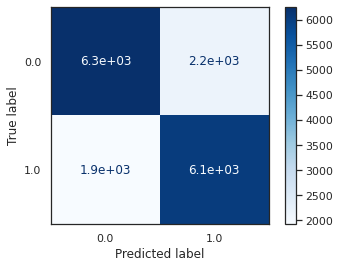

In [ ]:
# show confusion matrix of benchmark prediction
from sklearn.metrics import plot_confusion_matrix, accuracy_score

print("Accuracy = {0:.4f}".format(accuracy_score(val_y,first_lm.predict(val_X))))
plot_confusion_matrix(first_lm, val_X, val_y, val_y.unique(), cmap=plt.cm.Blues)

In [ ]:
if set_standardize:
    results_df.loc[len(results_df)] = ['Logistic Model - STD', accuracy_score(val_y,first_lm.predict(val_X))]
else:
    results_df.loc[len(results_df)] = ['Logistic Model', accuracy_score(val_y,first_lm.predict(val_X))]
    
results_df

,Approach,Accuracy
0,Logistic Model - STD,0.75096


### 3.1.2 Feature importance of basic model

In [ ]:
def feature_importance_LM(model, feature_names):
    return pd.DataFrame({'variable': feature_names, # Feature names
                         'coefficient': model.coef_[0] # Feature Coeficients
                    }) \
    .round(decimals=2) \
    .sort_values('coefficient', ascending=False) \
    .style.bar(color=['red', 'green'], align='zero')

feature_importance_LM(first_lm,train_X.columns)

,variable,coefficient
4,ct_health,0.720000
6,ct_armor,0.510000
13,ct_players_alive,0.480000
108,t_all_alive,0.390000
91,ct_assault,0.330000
35,ct_weapon_m4a4,0.260000
81,t_grenade_smokegrenade,0.240000
8,ct_money,0.190000
95,ct_sniper,0.180000
19,ct_weapon_awp,0.170000


## 3.2 Filtering Methods

### 3.2.1 CHI-SQUARED

chi-squared to check for significant associations of feature with target variable

pros: quick ranking, simple implementation

cons: does NOT consider interactions between variables

In [ ]:
if set_Chi2:
    
    # Check all the columns with unique values
    lista = []
    for col in train_X.columns:
        lista.append(len(train_X.loc[:,col].unique()))

    filter_unique= pd.Series(lista) !=1.0

    #If in the beginning of the script we take out the variables, then would also work 
    train_X_chi2 = train_X.loc[:,train_X.columns[filter_unique]]
    val_X_chi2 = val_X.loc[:,val_X.columns[filter_unique]]

    from sklearn.feature_selection import SelectKBest, chi2
    from math import log

    X, y = train_X_chi2, train_y ## check for all X DFs

    chi2_selector = SelectKBest(score_func=chi2,k=10).fit(X,y)

    # Get the indices sorted by most important to least important
    indices = np.argsort(chi2_selector.scores_)[::-1]

    chi2_features = []
    for i in range(len(X.columns)):
        chi2_features.append(X.columns[indices[i]])

    # Select the number n of top-n features
    chi2_features = chi2_features[0:40] # n = 40

    # Bar plot in Log-Scale

    plt.figure(figsize=(10,10))
    plt.yticks(rotation='horizontal',fontsize=16)
    plt.barh(chi2_features, np.log(chi2_selector.scores_[indices[range(sum(X.columns.isin(chi2_features)))]]), color='r', align='center')
    #plt.barh(chi2_features, chi2_selector.scores_[indices[range(sum(X.columns.isin(chi2_features)))]], color='r', align='center')
    plt.gca().invert_yaxis()
    plt.show()

    train_X = train_X.loc[:,chi2_features]
    val_X = val_X.loc[:,chi2_features]
    
else:
    pass

In [ ]:
# if set_Chi2 == True:
    
#     # deactivate n=40
    
#     # We will need to include this into each of the models, to select best number of features but with all the considerations (Chi, pca, lda...)

#     for i in range(1,len(chi2_features)):
#         print("Features used to train the model = {}".format(i))
#         print("Accuracy = {0:.4f}".format(accuracy_score(val_y,linear_model.LogisticRegression(max_iter=1000, penalty='none').fit(X_train[chi2_features[:i]], y_train).predict(X_test[chi2_features[:i]]))))
#         print()
#     chi2_initial_lm_mod = linear_model.LogisticRegression(max_iter=1000, penalty='none')
#     chi2_initial_lm_mod.fit(X_train[chi2_features[:6]], y_train)

In [ ]:
# rerun BM logit model

if set_Chi2:
    
    first_lm.fit(train_X, train_y) # refit on selected features
    
    print("Accuracy = {0:.4f}".format(accuracy_score(val_y,first_lm.predict(val_X))))
    plot_confusion_matrix(first_lm, val_X, val_y, val_y.unique(), cmap=plt.cm.Blues)
    
    results_df.loc[len(results_df)] = ['Logistic Model - CHI2', accuracy_score(val_y,first_lm.predict(val_X))]
    
else:
    pass

In [ ]:
results_df

,Approach,Accuracy
0,Logistic Model - STD,0.75096


### 3.2.2 INFORMATION GAIN

for all the categoricals / binned features

In [ ]:
if set_IG:

    from sklearn.feature_selection import SelectKBest, mutual_info_classif

    ig_selector = SelectKBest(score_func=mutual_info_classif).fit(train_X,train_y)

    # Get the indices sorted by most important to least important
    indices = np.argsort(ig_selector.scores_)[::-1]

    ig_features = []
    for i in range(len(train_X.columns)):
        ig_features.append(train_X.columns[indices[i]])

    # Now plot
    plt.figure(figsize=(10,10))
    plt.yticks(rotation='horizontal',fontsize=16)
    plt.barh(ig_features, ig_selector.scores_[indices[range(len(train_X.columns))]], color='r', align='center')
    plt.gca().invert_yaxis()
    plt.show()

    # Select the number n of top-n features ## could move this and apply the filter already for the plot
    ig_features = ig_features[0:40] # n = 40
    
    train_X = train_X.loc[:,ig_features]
    val_X = val_X.loc[:,ig_features]
    
else:
    pass 

In [ ]:
# rerun BM logit model

if set_IG:
    
    first_lm.fit(train_X, train_y) # refit on selected features
    
    print("Accuracy = {0:.4f}".format(accuracy_score(val_y,first_lm.predict(val_X))))
    plot_confusion_matrix(first_lm, val_X, val_y, val_y.unique(), cmap=plt.cm.Blues)
    
    if set_standardize:
        results_df.loc[len(results_df)] = ['Logistic Model - IG - STD', accuracy_score(val_y,first_lm.predict(val_X))]
    else:
        results_df.loc[len(results_df)] = ['Logistic Model - IG', accuracy_score(val_y,first_lm.predict(val_X))]
else:
    pass

In [ ]:
results_df

,Approach,Accuracy
0,Logistic Model - STD,0.75096


## 3.3 Embedded Methods

### 3.3.1 Lasso Regression

In [ ]:
if set_Lasso:

    from sklearn.feature_selection import SelectFromModel

    alphas = 10**np.linspace(-1,-4,100)

    lasso_mod_cv = linear_model.LogisticRegressionCV(max_iter=10000,penalty='l1',solver='liblinear',Cs=alphas,n_jobs=-3).fit(train_X, train_y)
    #lasso_mod_cv = linear_model.LogisticRegressionCV(max_iter=10000,penalty='l1',solver='saga',Cs=alphas,n_jobs=-3).fit(train_X, train_y)

    # rerun BM logit model

    # print("Accuracy = {0:.4f}".format(accuracy_score(val_y,lasso_mod_cv.predict(val_X))))
    # plot_confusion_matrix(lasso_mod_cv, val_X, val_y, val_y.unique(), cmap=plt.cm.Blues)

    # extract reduced set of features selected by Lasso

    model = SelectFromModel(lasso_mod_cv, prefit=True)
    new_X = model.transform(train_X) 
    val_new_X = model.transform(val_X)
    print("Original Number of Features = {} --> Number of features selected by Lasso = {}".format(train_X.shape[1], new_X.shape[1]))
    columns_lasso = train_X.columns[model.get_support()]
    print(columns_lasso)

    train_X = train_X.loc[:,columns_lasso]
    val_X = val_X.loc[:,columns_lasso]
    
else:
    pass

In [ ]:
# rerun BM logit model

if set_Lasso:
    
    first_lm.fit(train_X, train_y) # refit on selected features
    
    print("Accuracy = {0:.4f}".format(accuracy_score(val_y,first_lm.predict(val_X))))
    plot_confusion_matrix(first_lm, val_X, val_y, val_y.unique(), cmap=plt.cm.Blues)
    
    if set_standardize:
        results_df.loc[len(results_df)] = ['Logistic Model - Lasso - STD', accuracy_score(val_y,first_lm.predict(val_X))]
    else:
        results_df.loc[len(results_df)] = ['Logistic Model - Lasso', accuracy_score(val_y,first_lm.predict(val_X))]
    
else:
    pass

In [ ]:
results_df

,Approach,Accuracy
0,Logistic Model - STD,0.75096


### 3.3.2 Ridge Regression


In [ ]:
# # We perform Ridge to see what is the best score that we could obtain

# from sklearn.feature_selection import SelectFromModel
# alphas = 10**np.linspace(-1,-4,100)

# # There are 2 options for CV
# ridge_mod_cv = linear_model.RidgeClassifierCV(alphas=alphas).fit(train_X, train_y) #Performs better ## 74.94%, however running reduced # of feature only 72%
# ridge_mod_cv2 = linear_model.LogisticRegressionCV(max_iter=10000,penalty='l2',Cs=alphas,n_jobs=-3).fit(train_X, train_y) #performs at 74.1%

In [ ]:
# # rerun BM logit model

# print("Accuracy = {0:.4f}".format(accuracy_score(val_y,ridge_mod_cv.predict(val_X)))) #performs at 74.94%
# plot_confusion_matrix(ridge_mod_cv, val_X, val_y, val_y.unique(), cmap=plt.cm.Blues)

# model = SelectFromModel(ridge_mod_cv, prefit=True)
# new_X = model.transform(train_X)
# val_new_X = model.transform(val_X)
# print("Original Number of Features = {} --> Number of features selected by Ridge = {}".format(train_X.shape[1], new_X.shape[1]))
# columns_ridge = train_X.columns[model.get_support()]
# print(columns_ridge)

# set_ridge ==0
# if set_ridge == 1:
#     train_X = train_X.loc[:,columns_ridge]
#     val_X = val_X.loc[:,columns_ridge]
# else:
#     pass

In [ ]:
# # rerun BM logit model with reduced # of features

# ridge_mod_cv = linear_model.RidgeClassifierCV(alphas=alphas).fit(train_X.loc[:,columns_ridge], train_y) #Performs worse 72.21% 

# print("Accuracy = {0:.4f}".format(accuracy_score(val_y,ridge_mod_cv.predict(val_X.loc[:,columns_ridge]))))
# plot_confusion_matrix(ridge_mod_cv, val_X.loc[:,columns_ridge], val_y, val_y.unique(), cmap=plt.cm.Blues)
# print("Accuracy = {0:.4f}".format(accuracy_score(val_y,ridge_mod_cv2.predict(val_X)))) #Performs 74.10% 
# plot_confusion_matrix(ridge_mod_cv2, val_X, val_y, val_y.unique(), cmap=plt.cm.Blues)

# # We need to put whether ridge_mod_cv or ridge_mod_cv2 
# ridge_mod_cv = linear_model.RidgeClassifierCV(alphas=alphas).fit(train_X, train_y)
# results_df.loc[len(results_df)] = ['LR Baseline_Ridge', accuracy_score(val_y,ridge_mod_cv.predict(val_X))]
# results_df

## 3.4 Absolute Correlation


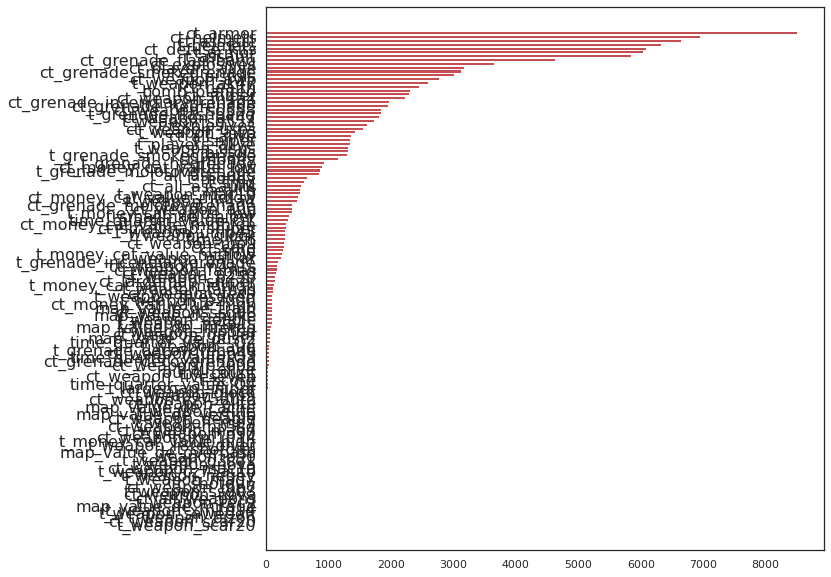

In [ ]:
if set_Corr:

    from sklearn.feature_selection import SelectKBest, f_classif

    f_selector = SelectKBest(score_func=f_classif).fit(train_X,train_y)

    # Get the indices sorted by most important to least important
    indices = np.argsort(f_selector.scores_)[::-1]

    f_features = []
    for i in range(len(train_X.columns)):
        f_features.append(train_X.columns[indices[i]])

    # Now plot
    plt.figure(figsize=(10,10))
    plt.yticks(rotation='horizontal',fontsize=16)
    plt.barh(f_features, f_selector.scores_[indices[range(len(train_X.columns))]], color='r', align='center')
    plt.gca().invert_yaxis()
    plt.show()

    # Select the number n of top-n features ## could move this and apply the filter already for the plot
    f_features = f_features[0:40] # n = 40
    
    train_X = train_X.loc[:,f_features]
    val_X = val_X.loc[:,f_features]
    
else:
    pass 

Accuracy = 0.7447


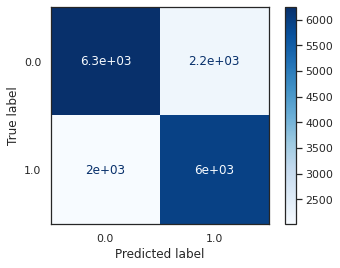

In [ ]:
# rerun BM logit model

if set_Corr:
    
    first_lm.fit(train_X, train_y) # refit on selected features
    
    print("Accuracy = {0:.4f}".format(accuracy_score(val_y,first_lm.predict(val_X))))
    plot_confusion_matrix(first_lm, val_X, val_y, val_y.unique(), cmap=plt.cm.Blues)
    
    if set_standardize:
        results_df.loc[len(results_df)] = ['Logistic Model - F-Score - STD', accuracy_score(val_y,first_lm.predict(val_X))]
    else:
        results_df.loc[len(results_df)] = ['Logistic Model - F-Score', accuracy_score(val_y,first_lm.predict(val_X))]
    
else:
    pass

In [ ]:
results_df

,Approach,Accuracy
0,Logistic Model - STD,0.750960
1,Logistic Model - F-Score - STD,0.744681


# 4. First Model - Linear Discriminant Analysis

To provide a solid first model, we estimate an LDA model. To work with a limited set up of features, we apply PCA as an additional pre-processing step.

a lot of variables, high correlations > apply PCA to reduce number of dimensions, then run LDA to give best possinle linear representation between classes (will end up w one vector only, linear combi of PCAs)

FIrst simple approach, no tuning required

## 4.1 DIMENSIONALITY REDUCTION - PCA

why PCA? maybe add another correlation plot
may not need every predictor
A weighted combination of predictors might be better
We should pick this combination to capture the “most information” possible
Benefits
Reduced number of predictors
Reduced noise (due to averaging)

In [ ]:
### standardization of data required

if set_PCA:

    from sklearn.decomposition import PCA 
    sklearn_pca = PCA()
    Y_sklearn = sklearn_pca.fit_transform(train_X) # using scaled train data

    VARIANCE_TO_KEEP = 0.90 # choose threshold of info to keep
    
    plt.bar(range(sklearn_pca.n_components_), sklearn_pca.explained_variance_ratio_, alpha=0.5, align='center',label='individual explained variance')
    plt.step(range(sklearn_pca.n_components_), [sklearn_pca.explained_variance_ratio_[:y].sum() for y in range(1,sklearn_pca.n_components_+1)], alpha=0.5, where='mid',label='cumulative explained variance')
    plt.axhline(y=VARIANCE_TO_KEEP, linewidth=2, color = 'r')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.xlim([0, sklearn_pca.n_components_])
    plt.legend(loc='best')
    plt.tight_layout()
    
    keep_recommend = [sklearn_pca.explained_variance_ratio_[:y].sum()>VARIANCE_TO_KEEP for y in range(1,sklearn_pca.n_components_+1)].count(False)
    print("Number of components to keep to retain %s%% of the variance:" % (100*VARIANCE_TO_KEEP), keep_recommend, "out of the original", sklearn_pca.n_components_)
    
    retained_components_number = keep_recommend # set the number of PCA variables to keep

    sklearn_pca_final = PCA(n_components=retained_components_number)

    Y_sklearn_final = sklearn_pca_final.fit_transform(train_X)
    Y2_sklearn_final = sklearn_pca_final.transform(val_X)
    
    train_X = pd.DataFrame(Y_sklearn_final, columns=[('PCA ' + str(i+1)) for i in range(sklearn_pca_final.n_components)])
    val_X = pd.DataFrame(Y2_sklearn_final, columns=[('PCA ' + str(i+1)) for i in range(sklearn_pca_final.n_components)])

In [ ]:
## instead use pipelines to be more efficient ## USE TO PREDICT ON FINAL TEST

# from sklearn.pipeline import Pipeline
# # fits PCA, transforms data and fits the decision tree classifier
# # on the transformed data
# pipe = Pipeline([('pca', PCA()),
#                  ('tree', DecisionTreeClassifier())])
# pipe.fit(iris.data, iris.target)
# pipe.predict(newdata)

## 4.2 Fit LDA Model

In [ ]:
if set_PCA:

    from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

    clf = LinearDiscriminantAnalysis()
    clf.fit(train_X, train_y)

    # show confusion matrix of benchmark prediction
    from sklearn.metrics import plot_confusion_matrix, accuracy_score

    print("Accuracy = {0:.4f}".format(accuracy_score(val_y,clf.predict(val_X))))
    plot_confusion_matrix(clf, val_X, val_y, val_y.unique(), cmap=plt.cm.Blues)
    
    results_df.loc[len(results_df)] = ['LDA Model - PCA/STD', accuracy_score(val_y,clf.predict(val_X))]


In [ ]:
results_df

,Approach,Accuracy
0,Logistic Model - STD,0.75096


# 5. Challenger Models

## 5.1 Random Forest

In [ ]:
# from sklearn.tree import DecisionTreeClassifier

# first_tree = DecisionTreeClassifier(random_state=42)
# first_tree.fit(train_X, train_y);

# from sklearn.metrics import accuracy_score

# predictions = first_tree.predict(val_X)
# print("Accuracy = {0:.4f}".format(accuracy_score(val_y, predictions)))
# # 0.79

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

tree_bagging = RandomForestClassifier(random_state=42, max_features=len(train_X.columns))
tree_bagging.fit(train_X, train_y)

predictions = tree_bagging.predict(val_X)
print("Accuracy = {0:.4f}".format(accuracy_score(val_y, predictions)))
#0.8547
#0.8349 unstd.

#### use randomized grid search for its shorter runtime

In [ ]:
# from sklearn.model_selection import RandomizedSearchCV

# params = {
#     "max_depth": [int(x) for x in np.linspace(5, 110, num = 5)]+[None],
#     "n_estimators": [int(x) for x in np.linspace(start = 50, stop = 1000, num = 5)],
#     "max_features": ['auto', 'log2', len(train_X.columns)],
#     "min_samples_split": [2, 5, 10],
#     "min_samples_leaf": [1, 2, 5]
# }

# search_TB = RandomizedSearchCV(tree_bagging, param_distributions=params, random_state=42, n_iter=50, cv=5, verbose=1, n_jobs=-1, return_train_score=True)
# search_TB.fit(train_X, train_y)

# print("Best parameters set found on development set:")
# print()
# print(search_TB.best_params_)
# print()
# print("Grid scores on development set:")
# print()
# means = search_TB.cv_results_['mean_test_score']
# stds = search_TB.cv_results_['std_test_score']
# for mean, std, params in zip(means, stds, search_TB.cv_results_['params']):
#     print("Accuracy = %0.3f (+/%0.03f) for %r" % (mean, std * 2, params))

# predictions = search_TB.best_estimator_.predict(val_X)

# print("Accuracy = {0:.4f}".format(accuracy_score(val_y,predictions)))
# #plot_confusion_matrix(search_TB.best_estimator_, val_X, val_y, val_y.unique(), cmap=plt.cm.Blues)

In [ ]:
# # from sklearn.ensemble import RandomForestClassifier
# # from sklearn.metrics import accuracy_score

# tree_rf = RandomForestClassifier(random_state=42, max_features='sqrt')
# tree_rf.fit(train_X, train_y)

# # predictions = tree_rf.predict(val_X)
# # print("Accuracy = {0:.4f}".format(accuracy_score(val_y, predictions)))
# # # 0.8487

In [ ]:
# plt.figure(figsize=(20,5))
# plt.bar(train_X.columns, tree_rf.feature_importances_)
# plt.title('Feature Importance', fontsize=16);

In [ ]:
# #OG2
# tree_rf_small = RandomForestClassifier(random_state=42, max_features='sqrt')
# tree_rf_small.fit(train_X.loc[:,tree_rf.feature_importances_>0.001], train_y)

# predictions = tree_rf_small.predict(val_X.loc[:,tree_rf.feature_importances_>0.001])
# print("Accuracy = {0:.4f}".format(accuracy_score(val_y, predictions)))
# # 0.8503

# # show confusion matrix of RF prediction

# from sklearn.metrics import plot_confusion_matrix, accuracy_score

# print("Accuracy = {0:.4f}".format(accuracy_score(val_y,tree_rf_small.predict(val_X.loc[:,tree_rf.feature_importances_>0.001]))))
# plot_confusion_matrix(tree_rf_small, val_X.loc[:,tree_rf.feature_importances_>0.001], val_y, val_y.unique(), cmap=plt.cm.Blues)

# results_df.loc[len(results_df)] = ['RF Base Model', accuracy_score(val_y,tree_rf_small.predict(val_X.loc[:,tree_rf.feature_importances_>0.001]))]
# results_df

## ExtraTrees

In [ ]:
## OG

from sklearn.ensemble import ExtraTreesClassifier
tree_et = ExtraTreesClassifier(random_state=42)
tree_et.fit(train_X, train_y)

predictions = tree_et.predict(val_X)
print("Accuracy = {0:.4f}".format(accuracy_score(val_y, predictions)))
# 0.8558
#0.8317 unstd.

In [ ]:
# show confusion matrix of ET prediction

from sklearn.metrics import plot_confusion_matrix, accuracy_score

print("Accuracy = {0:.4f}".format(accuracy_score(val_y,tree_et.predict(val_X))))
plot_confusion_matrix(tree_et, val_X, val_y, val_y.unique(), cmap=plt.cm.Blues)

results_df.loc[len(results_df)] = ['ET Base Model', accuracy_score(val_y,tree_et.predict(val_X))]
results_df

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

params = {
    "max_depth": [int(x) for x in np.linspace(20, 100, num = 8)]+[None],
    "criterion": ['gini', 'entropy'],
    "n_estimators": [int(x) for x in np.linspace(start = 10, stop = 4000, num = 8)],
    "min_samples_split": [2, 4, 6],
    "min_samples_leaf": [1, 2, 3]
}

search_ET = RandomizedSearchCV(tree_et, param_distributions=params, random_state=42, n_iter=50, cv=5, verbose=1, n_jobs=-1, return_train_score=True)
search_ET.fit(train_X, train_y)

print("Best parameters set found on development set:")
print()
print(search_ET.best_params_)
print()
print("Grid scores on development set:")
print()
means = search_ET.cv_results_['mean_test_score']
stds = search_ET.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, search_ET.cv_results_['params']):
    print("Accuracy = %0.3f (+/%0.03f) for %r" % (mean, std * 2, params))

predictions = search_ET.best_estimator_.predict(val_X)

import json

json.dump(search_ET.best_params_, open('ExtraTrees_params7fTest.json', 'w'))
#json.dump(search_ET.best_params_, open('/content/drive/Shared drives/ML2 project/ExtraTrees_params7fTest.json', 'w')) # for Collab

In [ ]:
# show confusion matrix of ET Randomized prediction

from sklearn.metrics import plot_confusion_matrix, accuracy_score

print("Accuracy = {0:.4f}".format(accuracy_score(val_y,predictions)))
plot_confusion_matrix(search_ET.best_estimator_, val_X, val_y, val_y.unique(), cmap=plt.cm.Blues)

results_df.loc[len(results_df)] = ['ET Randomized Model', accuracy_score(val_y,search_ET.predict(val_X))]
results_df

In [ ]:
# from sklearn.ensemble import AdaBoostClassifier
# tree_ab = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
#                          algorithm="SAMME",
#                          n_estimators=200)
# tree_ab.fit(train_X, train_y)

# predictions = tree_ab.predict(val_X)
# print("Accuracy = {0:.4f}".format(accuracy_score(val_y, predictions)))

In [ ]:
# from sklearn.ensemble import GradientBoostingClassifier
# tree_gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=42)
# tree_gbc.fit(train_X, train_y)

# predictions = tree_gbc.predict(val_X)
# print("Accuracy = {0:.4f}".format(accuracy_score(val_y, predictions)))

## 5.2  XGBoost

idea of boosted trees

In [ ]:
#conda install -c conda-forge xgboost
import xgboost
xgb_tree = xgboost.XGBClassifier(objective="binary:logistic", random_state=42)

from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV

params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3), # default 0.1 
    "max_depth": randint(2, 6), # default 3
    "n_estimators": randint(50, 200), # default 100
    "subsample": uniform(0.6, 0.4)
}

search_XGB = RandomizedSearchCV(xgb_tree, param_distributions=params, random_state=42, n_iter=50, cv=5, verbose=1, n_jobs=-1, return_train_score=True)
search_XGB.fit(train_X, train_y)

print("Best parameters set found on development set:")
print()
print(search_XGB.best_params_)
print()
print("Grid scores on development set:")
print()
means = search_XGB.cv_results_['mean_test_score']
stds = search_XGB.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, search_XGB.cv_results_['params']):
    print("Accuracy = %0.3f (+/%0.03f) for %r" % (mean, std * 2, params))
    
predictions = search_XGB.best_estimator_.predict(val_X)

print("Accuracy = {0:.4f}".format(accuracy_score(val_y,predictions)))
plot_confusion_matrix(search_XGB.best_estimator_, val_X, val_y, val_y.unique(), cmap=plt.cm.Blues)

import json

json.dump(search_XGB.best_params_, open('XGBoost_params7fTest.json', 'w'))
#json.dump(search_XGB.best_params_, open('/content/drive/Shared drives/ML2 project/XGBoost_params7fTest.json', 'w')) # for Collab

results_df.loc[len(results_df)] = ['XGBoost Model', accuracy_score(val_y,predictions)]
results_df

## 5.3 Support Vector Machines [SVM]

In [ ]:
# from sklearn import svm
# from sklearn.model_selection import GridSearchCV

# param_grid = {
#     "C":[1,5,10,100], 
#     "gamma":[0.01,0.0001,0.00001]
# }

# estimator = GridSearchCV(svm.SVC(kernel='rbf'), param_grid, cv=5)
# estimator.fit(X_train, y_train);

# print("The best parameters are %s with a score of %0.2f"
#       % (estimator.best_params_, estimator.best_score_))


# scores = estimator.cv_results_['mean_test_score'].reshape(len(param_grid['C']), len(param_grid['gamma']))

# # Draw heatmap of the validation accuracy as a function of gamma and C

# plt.figure(figsize=(10, 10))
# plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
# plt.imshow(scores, interpolation='nearest', cmap=plt.cm.Blues)
# plt.xlabel('gamma')
# plt.ylabel('C')
# plt.colorbar()
# plt.xticks(np.arange(len(param_grid['gamma'])), param_grid['gamma'], rotation=45)
# plt.yticks(np.arange(len(param_grid['C'])), param_grid['C'])
# plt.title('Validation accuracy')
# plt.show()

Fitting 5 folds for each of 4 candidates, totalling 20 fits


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 4 is smaller than n_iter=50. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 93.6min finished


Best parameters set found on development set:

{'kernel': 'rbf'}

Grid scores on development set:

Accuracy = 0.750 (+/0.007) for {'kernel': 'linear'}
Accuracy = 0.759 (+/0.005) for {'kernel': 'poly'}
Accuracy = 0.760 (+/0.004) for {'kernel': 'rbf'}
Accuracy = 0.670 (+/0.006) for {'kernel': 'sigmoid'}
Accuracy = 0.7609


NameError: ignored

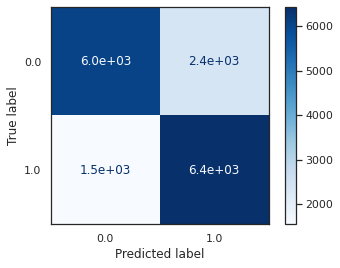

In [ ]:
from sklearn import svm
from sklearn.model_selection import RandomizedSearchCV

svm_basic = svm.SVC(random_state = 42)

params = {
     "C":[1,5,10,100], 
     "gamma":[0.01,0.0001,"scale","auto"],
     "kernel":["poly","rbf"],
     "degree":[3,4],
 }

search_SVM = RandomizedSearchCV(svm_basic, param_distributions=params, random_state=42, n_jobs=-1, n_iter=50, cv=5, verbose=1, return_train_score=True)
search_SVM.fit(train_X, train_y)

print("Best parameters set found on development set:")
print()
print(search_SVM.best_params_)
print()
print("Grid scores on development set:")
print()
means = search_SVM.cv_results_['mean_test_score']
stds = search_SVM.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, search_SVM.cv_results_['params']):
    print("Accuracy = %0.3f (+/%0.03f) for %r" % (mean, std * 2, params))
    
predictions = search_SVM.best_estimator_.predict(val_X)

print("Accuracy = {0:.4f}".format(accuracy_score(val_y,predictions)))
plot_confusion_matrix(search_SVM.best_estimator_, val_X, val_y, val_y.unique(), cmap=plt.cm.Blues)

import json
json.dump(search_SVM.best_params_, open('SVM_params7fTest.json', 'w'))
#json.dump(search_SVM.best_params_, open('/content/drive/Shared drives/ML2 project/SVM_params7fTest.json', 'w')) # for Collab

results_df.loc[len(results_df)] = ['SVM Model', accuracy_score(val_y,predictions)]
results_df

In [ ]:
# from sklearn import svm, pipeline
# from sklearn.kernel_approximation import Nystroem
# from sklearn.model_selection import GridSearchCV

# feature_map_nystroem = Nystroem(gamma=.1,
#                                 random_state=42)

# nystroem_SVM = pipeline.Pipeline([('kernel_map', feature_map_nystroem),
#                                   ('SVM', svm.LinearSVC())])

# param_grid = {
#     'kernel_map__n_components': [int(x) for x in np.linspace(50, 350, num = 4)],
#     'SVM__C': [1,5,10,100],
#     #'SVM__gamma': [0.01,0.0001,0.00001]
# }

# searchSVM = GridSearchCV(nystroem_SVM, param_grid)
# searchSVM.fit(train_X,train_y)

# print("Best parameters set found on development set:")
# print()
# print(searchSVM.best_params_)
# print()
# print("Grid scores on development set:")
# print()
# means = searchSVM.cv_results_['mean_test_score']
# stds = searchSVM.cv_results_['std_test_score']
# for mean, std, params in zip(means, stds, searchSVM.cv_results_['params']):
#     print("Accuracy = %0.3f (+/%0.03f) for %r" % (mean, std * 2, params))

# predictions = searchSVM.best_estimator_.predict(val_X)

# print("Accuracy = {0:.4f}".format(accuracy_score(val_y,predictions)))
# plot_confusion_matrix(searchSVM.best_estimator_, val_X, val_y, val_y.unique(), cmap=plt.cm.Blues)

## 5.4 K-nearest Neighbours

# 6. Ensemble Method

Trend in many machine learning challenges and applications nowadays to work with a combination of ML approaches, weighing their predictions. For instance, majority vote or simple assignment of weights are frequently applied.

## 6.1 Voting Classifier

#### TREND OF ENSEMBLE METHODS

combination of previously estimated models

In [ ]:
from sklearn.ensemble import VotingClassifier
#from sklearn.naive_bayes import GaussianNB
#from sklearn.linear_model import LogisticRegression

clf1 = search_ET.best_estimator_
clf2 = search_XGB.best_estimator_
clf3 = search_SVM.best_estimator_
#clf4 = #anyothermodel

vote_hard = VotingClassifier(estimators=[
        ('extraTrees', clf1), ('xgBoost', clf2), ('SVM', clf3)], voting='hard')
vote_hard = vote_hard.fit(train_X, train_y)
print(vote_hard.predict(val_X))

#np.array_equal(vote_hard.named_estimators_.lr.predict(val_X),
#               vote_hard.named_estimators_['lr'].predict(val_X))

vote_soft = VotingClassifier(estimators=[
        ('extraTrees', clf1), ('xgBoost', clf2), ('SVM', clf3)],
        voting='soft')
vote_soft = vote_soft.fit(train_X, train_y)
#print(vote_soft.predict(val_X))

##
# FOR WEIGHTS, APPLY GRID-SEARCH
##
vote_weighted = VotingClassifier(estimators=[
       ('extraTrees', clf1), ('xgBoost', clf2), ('SVM', clf3)],
       voting='soft', weights=[2,1,2],
       flatten_transform=True)
vote_weighted = vote_weighted.fit(train_X, train_y)
#print(vote_weighted.predict(val_X))

#print(vote_weighted.transform(train_X).shape)

In [ ]:
## hard voting 86% and weighted 84% work well

In [ ]:
# show confusion matrix of vote 1 (hard)

from sklearn.metrics import plot_confusion_matrix, accuracy_score

print("Accuracy = {0:.4f}".format(accuracy_score(val_y,vote_hard.predict(val_X))))
plot_confusion_matrix(vote_hard, val_X, val_y, val_y.unique(), cmap=plt.cm.Blues)

# 0.8606

In [ ]:
results_df.loc[len(results_df)] = ['Voting E-Model 1', accuracy_score(val_y,vote_hard.predict(val_X))]
results_df

In [ ]:
# show confusion matrix of vote 2 (soft)

from sklearn.metrics import plot_confusion_matrix, accuracy_score

print("Accuracy = {0:.4f}".format(accuracy_score(val_y,vote_soft.predict(val_X))))
plot_confusion_matrix(vote_soft, val_X, val_y, val_y.unique(), cmap=plt.cm.Blues)

In [ ]:
results_df.loc[len(results_df)] = ['Voting E-Model 2', accuracy_score(val_y,vote_soft.predict(val_X))]
results_df

In [ ]:
# show confusion matrix of vote 3 (weighted)

from sklearn.metrics import plot_confusion_matrix, accuracy_score

print("Accuracy = {0:.4f}".format(accuracy_score(val_y,vote_weighted.predict(val_X))))
plot_confusion_matrix(vote_weighted, val_X, val_y, val_y.unique(), cmap=plt.cm.Blues)

In [ ]:
results_df.loc[len(results_df)] = ['Voting E-Model 3', accuracy_score(val_y,vote_weighted.predict(val_X))]
results_df

## 6.2 Stacking Classifier

In [ ]:
# conda install -c conda-forge xgboost -y

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
import xgboost

estimators = [
    ('rf', RandomForestClassifier(n_estimators=10, random_state=42)),
    ('svr',LinearSVC(random_state=42)),
    ('xgb',xgboost.XGBClassifier(objective="binary:logistic", random_state=42))
]

stack1 = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression()
)

stack1.fit(train_X, train_y).score(val_X, val_y)

In [ ]:
# show confusion matrix of benchmark prediction

from sklearn.metrics import plot_confusion_matrix, accuracy_score

print("Accuracy = {0:.4f}".format(accuracy_score(val_y,stack1.predict(val_X))))
plot_confusion_matrix(stack1, val_X, val_y, val_y.unique(), cmap=plt.cm.Blues)

# 0.8204

In [ ]:
results_df.loc[len(results_df)] = ['Stacking E-Model', accuracy_score(val_y,stack1.predict(val_X))]
results_df

In [ ]:
# Export results_df ### make sure to adjust 

results_df.to_csv('results7fTest.csv', index=False)
#results_df.to_csv(open('/content/drive/Shared drives/ML2 project/results7fTest.csv', 'w'), index=False)

In [ ]:
# Display results_df

models = pd.DataFrame(results_df.iloc[:,0])
accuracy = pd.DataFrame(round(results_df.iloc[:,1],5))

df = pd.concat([models,accuracy],axis=1)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import six

def render_mpl_table(data, col_width=10.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, cellLoc='center', bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax

render_mpl_table(df, header_columns=0, col_width=5.0)

plt.savefig('results_df7fTest.png') # not for Google Collab